### GENERATE TRAJECTORIES USING **DOUBLE-WELL POTENTIAL**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as kB
from numpy.random import randn as gauss
from numpy.random import rand as uniform

### Physical parameters 
R = 1e-7                                # Radius of the Brownian particle [m]
eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
T = 300                                 # Temperature [K]
L0 = 2e-6                               # Reference distance from middle to one minimum [m]
H0 = kB*300                             # Barrier height [Joule]
gamma0 = 6 * np.pi * eta * R            # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 1000                   # Number of samples of the trajectory
Dt = 1e-2                  # Timestep 
oversampling = 5           # Simulation oversampling
offset = 1000              # Number of equilibration timesteps
batch_size = 32            # Number of trajectories

### Define functions to scale and rescale inputs
scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units

### Define function to scale and rescale targets
scale_targets = lambda L, H: [L/L0 -1, np.log(H / H0)]                        # Scales targets to order 1
rescale_targets = lambda scaled_L, scaled_H: [(1 + scaled_L)*L0*1e6, 
                                              np.exp(scaled_H) * H0/kB/300] # Inverse of targets_scaling

def simulate_trajectory(batch_size=batch_size, 
                        T=T,
                        H0=H0,
                        L0=L0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset):#, 
                        #scale_inputs=scale_inputs, 
                        #scale_targets=scale_targets):
    
    ### Randomize trajectory parameters
    L = L0 * (uniform(batch_size)+.5) 
    H = H0 * 10**(uniform(batch_size)*1.75 - .75)       # Generates random values for computing the stiffness
    gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

    ### Simulate
    dt = Dt / oversampling                 # time step of the simulation
    x = np.zeros((batch_size, N))          # initialization of the x array
    k0 = 4*H/L**2 
    k1 = 4*H/L**4
    D = kB * T / gamma                     # diffusion coefficient
    C1 = +k0 / gamma * dt
    C2 = -k1 / gamma * dt                  # drift coefficient of the Langevin equation
    C3 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
    X = x[:, 0]
    n = 0
    
    for t in range(offset):                      # Offset (for some prerun before running)
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        #X = X - (2 * X**3) + (12 * X**2) - (18 * X) + 3 + (C3 * gauss(batch_size))
        
    for t in range(N * oversampling):            # Simulation                
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        #X = X - (2 * X**3) + (12 * X**2) - (18 * X) + 3 + (C3 * gauss(batch_size))
        if t % oversampling == 0:                # We save every oversampling^th values 
            x[:, n] = X 
            n += 1

    inputs = scale_inputs(x)
    targets = np.swapaxes(scale_targets(*[L, H]),0,1)
    target_reals = np.swapaxes([L*1e6, H/kB/300],0,1)

    return inputs, targets, target_reals

##### TRAIN THE DEEP NEURAL NETWORK

In [2]:
def train_deep_learning_network(
    network,
    simulate_trajectory,
    sample_sizes = (32, 128, 512),#(32, 128, 512, 2048),
    iteration_numbers = (3001, 2001, 1001),#(1001, 2001, 3001),#(3001, 2001, 1001, 101),
    verbose=.1):
    """Train a deep learning network.
    
    Input:
    network: deep learning network
    simulate_trajectory: trajectory generator function
    sample_sizes: sizes of the batches of trajectories used in the training [tuple of positive integers]
    iteration_numbers: numbers of batches used in the training [tuple of positive integers]
    verbose: frequency of the update messages [number between 0 and 1]
        
    Output:
    training_history: dictionary with training history
    """  
    
    import numpy as np
    from time import time
     
    training_history = {}
    training_history['Sample Size'] = []
    training_history['Iteration Number'] = []
    training_history['Iteration Time'] = []
    training_history['MSE'] = []
    training_history['MAE'] = []
    
    for sample_size, iteration_number in zip(sample_sizes, iteration_numbers):
        for iteration in range(iteration_number):
            
            # measure initial time for iteration
            initial_time = time()

            # generate trajectories and targets
            network_blocksize = network.get_layer(index=0).get_config()['batch_input_shape'][1:][1]                        
            number_of_outputs = network.get_layer(index=-1).get_config()['units']
            output_shape = (sample_size, number_of_outputs)
            targets = np.zeros(output_shape)
            
            
            batch_size = sample_size
            trajectory, target, target_real = simulate_trajectory(batch_size)
            #trajectory = trajectory.scaled_values
            trajectory_dimensions = [sample_size, round(trajectory.size/network_blocksize/sample_size), network_blocksize]
            trajectories = np.array(trajectory).reshape(trajectory_dimensions)
            targets = target#.scaled_values
                
                

            # training
            history = network.fit(trajectories,
                                targets,
                                epochs=1, 
                                batch_size=sample_size,
                                verbose=False)
                        
            # measure elapsed time during iteration
            iteration_time = time() - initial_time

            # record training history
            mse = history.history['mse'][0]
            mae = history.history['mae'][0]
                        
            training_history['Sample Size'].append(sample_size)
            training_history['Iteration Number'].append(iteration)
            training_history['Iteration Time'].append(iteration_time)
            training_history['MSE'].append(mse)
            training_history['MAE'].append(mae)

            if not(iteration%int(verbose**-1)):
                print('Sample size %6d   iteration number %6d   MSE %10.4f   MAE %10.4f   Time %10f ms' % (sample_size, iteration + 1, mse, mae, iteration_time * 1000))
                
    return training_history

##### PLOT THE PERFORMANCE

In [3]:
def plot_learning_performance(training_history, number_of_timesteps_for_average = 100, figsize=(20,20)):
    """Plot the learning performance of the deep learning network.
    
    Input:
    training_history: dictionary with training history, typically obtained from train_deep_learning_network()
    number_of_timesteps_for_average: length of the average [positive integer number]
    figsize: figure size [list of two positive numbers]
        
    Output: none
    """    

    import matplotlib.pyplot as plt
    from numpy import convolve, ones
    
    plt.figure(figsize=figsize)

    plt.subplot(5, 1, 1)
    plt.semilogy(training_history['MSE'], 'k')
    plt.semilogy(convolve(training_history['MSE'], ones(number_of_timesteps_for_average) / number_of_timesteps_for_average, mode='valid'), 'r')
    plt.ylabel('MSE', fontsize=24)
    plt.xlabel('Epochs', fontsize=24)

    plt.subplot(5, 1, 2)
    plt.semilogy(training_history['MAE'], 'k')
    plt.semilogy(convolve(training_history['MAE'], ones(number_of_timesteps_for_average) / number_of_timesteps_for_average, mode='valid'), 'r')
    plt.ylabel('MAE', fontsize=24)
    plt.xlabel('Epochs', fontsize=24)
    plt.show()

##### TEST THE DNN ON NEW SIMULATED TRAJECTORIES

In [4]:
def predict(network, trajectory):
    """ Predict parameters of the force field from the trajectory using the deep learnign network.
    
    Inputs:
    network: deep learning network
    image: trajectroy [numpy array of real numbers]
    
    Output:
    predicted_targets: predicted parameters of the calibrated force field [1D numpy array containing outputs]
    """
    
    from numpy import reshape
    
    network_blocksize = network.get_layer(index=0).get_config()['batch_input_shape'][1:][1]
    predicted_targets = network.predict(reshape(trajectory, [1,round(trajectory.size/network_blocksize),network_blocksize]))   
        
    return predicted_targets


def test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show=100):#, dt = 1e-1):

    
    network_blocksize = network.get_layer(index=0).get_config()['batch_input_shape'][1:][1]


    predictions_scaled = []
    predictions_physical = []

    batch_size = number_of_predictions_to_show
    trajectory, targets, targets_real = simulate_trajectory(batch_size)
    targets_physical = list(targets_real)#targets.values)
    targets_scaled = list(targets)#.scaled_values)
    #trajectory = trajectory.scaled_values
    trajectory_dimensions = [number_of_predictions_to_show, round(trajectory.size/network_blocksize/number_of_predictions_to_show) , network_blocksize]
    trajectories = np.array(trajectory).reshape(trajectory_dimensions)
       

    for i in range(number_of_predictions_to_show):
        predictions = predict(network, trajectories[i])


        predictions_scaled.append(predictions[0])
        predictions_physical.append(rescale_targets(*predictions[0]))

    number_of_outputs = network.get_layer(index=-1).get_config()['units']    

    targets_physical = np.array(targets_physical).transpose()
    targets_scaled = np.array(targets_scaled).transpose()
    predictions_scaled = np.array(predictions_scaled).transpose()
    predictions_physical = np.array(predictions_physical).transpose()

    # Do not show results at the edges of the training range 

    if number_of_outputs>1:

        ind = np.isfinite(targets_scaled[0])
        for target_number in range(number_of_outputs):
            target_max = .9 * np.max(targets_scaled[target_number]) + .1 * np.min(targets_scaled[target_number])
            target_min = .1 * np.max(targets_scaled[target_number]) + .9 * np.min(targets_scaled[target_number])
            ind = np.logical_and(ind, targets_scaled[target_number] < target_max)
            ind = np.logical_and(ind, targets_scaled[target_number] > target_min)
    else:
        target_max = .9 * np.max(targets_scaled) + .1 * np.min(targets_scaled)
        target_min = .1 * np.max(targets_scaled) + .9 * np.min(targets_scaled)
        ind = np.logical_and(targets_scaled < target_max, targets_scaled > target_min)

    return targets_scaled, targets_physical, predictions_scaled, predictions_physical


def plot_test_performance(targets_scaled, targets_physical, predictions_scaled, predictions_physical, network):
    
    import matplotlib.pyplot as plt
    import numpy as np
    #from . import predict

    number_of_outputs = network.get_layer(index=-1).get_config()['units']    
    
    if number_of_outputs>1:

        for target_number in range(number_of_outputs):
            plt.figure(figsize=(20, 10))

            plt.subplot(121)
            plt.plot(targets_scaled[target_number],
                     predictions_scaled[target_number],
                     '.')
            #plt.xlabel(targets.scalings[target_number], fontsize=18)
            #plt.ylabel('Predicted ' + targets.scalings[target_number], fontsize=18)
            plt.axis('square')
            plt.title('Prediction performance in scaled units', fontsize=18)

            plt.subplot(122)
            plt.plot(targets_physical[target_number],
                     predictions_physical[target_number],
                    '.')
            #plt.xlabel(targets.names[target_number], fontsize=18)
            #plt.ylabel('Predicted ' + targets.names[target_number], fontsize=18)
            plt.axis('square')
            plt.title('Prediction performance in real units', fontsize=18)


    else: 
        plt.figure(figsize=(20, 10))

        plt.subplot(121)
        plt.plot(targets_scaled[ind],
                 predictions_scaled.transpose()[ind],
                 '.')
        #plt.xlabel(targets.scalings[0], fontsize=18)
        #plt.ylabel('Predicted ' + targets.scalings[0], fontsize=18)
        plt.axis('square')
        plt.title('Prediction performance in scaled units', fontsize=18)

        plt.subplot(122)
        plt.plot(targets_physical[ind],
                 predictions_physical.transpose()[ind],
                '.')
        #plt.xlabel(targets.names[0], fontsize=18)
        #plt.ylabel('Predicted ' + targets.names[0], fontsize=18)
        plt.axis('square')
        plt.title('Prediction performance in real units', fontsize=18)

## GRU

CREATE MODEL

In [5]:
def create_deep_learning_network(
    input_shape=(None, 50),
    lstm_layers_dimensions=(100, 50),
    number_of_outputs=2) :
    """Creates and compiles a deep learning network.
    
    Inputs:    
    input_shape: Should be the same size of the input trajectory []
    lstm_layers_dimensions: number of neurons in each LSTM layer [tuple of positive integers]
        
    Output:
    network: deep learning network
    """    

    from keras import models, layers, optimizers
    
    ### INITIALIZE DEEP LEARNING NETWORK
    network = models.Sequential()

    ### CONVOLUTIONAL BASIS
    for lstm_layer_number, lstm_layer_dimension in zip(range(len(lstm_layers_dimensions)), lstm_layers_dimensions):

        # add LSTM layer
        lstm_layer_name = 'lstm_' + str(lstm_layer_number + 1)
        if lstm_layer_number + 1 < len(lstm_layers_dimensions): # All layers but last
            lstm_layer = layers.GRU(lstm_layer_dimension,
                                     return_sequences=True,
                                     dropout=0,
                                     recurrent_dropout=0,
                                     input_shape=input_shape,
                                     name=lstm_layer_name)
        else: # Last layer
            lstm_layer = layers.GRU(lstm_layer_dimension,
                                     return_sequences=False,
                                     dropout=0,
                                     recurrent_dropout=0,
                                     input_shape=input_shape,
                                     name=lstm_layer_name)

        network.add(lstm_layer)
    # OUTPUT LAYER
    output_layer = layers.Dense(number_of_outputs, name='output')
    network.add(output_layer)
    
    network.compile(optimizer=optimizers.Adam(lr=1e-3), loss='mse', metrics=['mse', 'mae'])
    
    return network

In [6]:
### Create deep learning network
networkGRU = create_deep_learning_network()

### Print deep learning network summary
networkGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (GRU)                (None, None, 100)         45600     
                                                                 
 lstm_2 (GRU)                (None, 50)                22800     
                                                                 
 output (Dense)              (None, 2)                 102       
                                                                 
Total params: 68,502
Trainable params: 68,502
Non-trainable params: 0
_________________________________________________________________


C:\Users\fap_9\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### TRAIN MODEL

In [7]:
%%time

training_history_GRU = train_deep_learning_network(networkGRU, simulate_trajectory)

Sample size     32   iteration number      1   MSE     1.0204   MAE     0.7532   Time 2342.982054 ms
Sample size     32   iteration number     11   MSE     0.6593   MAE     0.5590   Time 118.805885 ms
Sample size     32   iteration number     21   MSE     0.4899   MAE     0.5148   Time 191.372633 ms
Sample size     32   iteration number     31   MSE     0.4528   MAE     0.4521   Time 114.611864 ms
Sample size     32   iteration number     41   MSE     0.5150   MAE     0.5033   Time 157.884121 ms
Sample size     32   iteration number     51   MSE     0.5087   MAE     0.4737   Time 207.269192 ms
Sample size     32   iteration number     61   MSE     0.2484   MAE     0.3566   Time 130.165339 ms
Sample size     32   iteration number     71   MSE     0.3815   MAE     0.4381   Time 139.592648 ms
Sample size     32   iteration number     81   MSE     0.2626   MAE     0.3372   Time 141.762257 ms
Sample size     32   iteration number     91   MSE     0.4233   MAE     0.4132   Time 143.535376 ms

Sample size     32   iteration number    821   MSE     0.1819   MAE     0.2789   Time 174.332619 ms
Sample size     32   iteration number    831   MSE     0.1104   MAE     0.2390   Time 139.641047 ms
Sample size     32   iteration number    841   MSE     0.1183   MAE     0.2328   Time 112.892628 ms
Sample size     32   iteration number    851   MSE     0.1786   MAE     0.2774   Time 176.908016 ms
Sample size     32   iteration number    861   MSE     0.1788   MAE     0.2897   Time 203.233957 ms
Sample size     32   iteration number    871   MSE     0.0998   MAE     0.2030   Time 157.013655 ms
Sample size     32   iteration number    881   MSE     0.1218   MAE     0.2342   Time 130.397081 ms
Sample size     32   iteration number    891   MSE     0.2282   MAE     0.3204   Time 150.813580 ms
Sample size     32   iteration number    901   MSE     0.1149   MAE     0.2213   Time 126.035929 ms
Sample size     32   iteration number    911   MSE     0.1353   MAE     0.2566   Time 155.895233 ms


Sample size     32   iteration number   1641   MSE     0.1933   MAE     0.2968   Time 157.257318 ms
Sample size     32   iteration number   1651   MSE     0.1899   MAE     0.2597   Time 156.908274 ms
Sample size     32   iteration number   1661   MSE     0.2462   MAE     0.3124   Time 163.447142 ms
Sample size     32   iteration number   1671   MSE     0.0766   MAE     0.1855   Time 166.458368 ms
Sample size     32   iteration number   1681   MSE     0.1428   MAE     0.2471   Time 172.990799 ms
Sample size     32   iteration number   1691   MSE     0.1372   MAE     0.2313   Time 162.686348 ms
Sample size     32   iteration number   1701   MSE     0.1192   MAE     0.2283   Time 137.127638 ms
Sample size     32   iteration number   1711   MSE     0.1914   MAE     0.2584   Time 141.356468 ms
Sample size     32   iteration number   1721   MSE     0.2252   MAE     0.3041   Time 170.387268 ms
Sample size     32   iteration number   1731   MSE     0.1666   MAE     0.2574   Time 189.135075 ms


Sample size     32   iteration number   2461   MSE     0.0757   MAE     0.1853   Time 176.668882 ms
Sample size     32   iteration number   2471   MSE     0.1088   MAE     0.2165   Time 207.947254 ms
Sample size     32   iteration number   2481   MSE     0.1146   MAE     0.1944   Time 246.067047 ms
Sample size     32   iteration number   2491   MSE     0.1555   MAE     0.2262   Time 169.357300 ms
Sample size     32   iteration number   2501   MSE     0.1330   MAE     0.2285   Time 184.976339 ms
Sample size     32   iteration number   2511   MSE     0.0556   MAE     0.1543   Time 172.618389 ms
Sample size     32   iteration number   2521   MSE     0.0844   MAE     0.1843   Time 245.349407 ms
Sample size     32   iteration number   2531   MSE     0.1457   MAE     0.2580   Time 188.292265 ms
Sample size     32   iteration number   2541   MSE     0.1411   MAE     0.2114   Time 185.324192 ms
Sample size     32   iteration number   2551   MSE     0.0971   MAE     0.2089   Time 166.411400 ms


Sample size    128   iteration number    271   MSE     0.0933   MAE     0.1924   Time 567.891598 ms
Sample size    128   iteration number    281   MSE     0.1065   MAE     0.1993   Time 403.136015 ms
Sample size    128   iteration number    291   MSE     0.1225   MAE     0.2110   Time 330.483675 ms
Sample size    128   iteration number    301   MSE     0.1170   MAE     0.2130   Time 616.222620 ms
Sample size    128   iteration number    311   MSE     0.0883   MAE     0.1911   Time 551.888943 ms
Sample size    128   iteration number    321   MSE     0.1303   MAE     0.2130   Time 359.276533 ms
Sample size    128   iteration number    331   MSE     0.1016   MAE     0.1944   Time 643.322229 ms
Sample size    128   iteration number    341   MSE     0.1359   MAE     0.2311   Time 378.116131 ms
Sample size    128   iteration number    351   MSE     0.1082   MAE     0.2012   Time 360.939026 ms
Sample size    128   iteration number    361   MSE     0.0927   MAE     0.1926   Time 736.128569 ms


Sample size    128   iteration number   1091   MSE     0.1085   MAE     0.2084   Time 527.821302 ms
Sample size    128   iteration number   1101   MSE     0.1175   MAE     0.2133   Time 689.412594 ms
Sample size    128   iteration number   1111   MSE     0.0994   MAE     0.1996   Time 454.520941 ms
Sample size    128   iteration number   1121   MSE     0.0906   MAE     0.1936   Time 714.830399 ms
Sample size    128   iteration number   1131   MSE     0.0974   MAE     0.1919   Time 550.548792 ms
Sample size    128   iteration number   1141   MSE     0.0996   MAE     0.1936   Time 371.993065 ms
Sample size    128   iteration number   1151   MSE     0.1052   MAE     0.1968   Time 451.394796 ms
Sample size    128   iteration number   1161   MSE     0.1156   MAE     0.2005   Time 574.445724 ms
Sample size    128   iteration number   1171   MSE     0.1292   MAE     0.2283   Time 550.621033 ms
Sample size    128   iteration number   1181   MSE     0.1056   MAE     0.1944   Time 547.953367 ms


Sample size    128   iteration number   1911   MSE     0.1281   MAE     0.2188   Time 663.206100 ms
Sample size    128   iteration number   1921   MSE     0.1094   MAE     0.2059   Time 620.642900 ms
Sample size    128   iteration number   1931   MSE     0.0788   MAE     0.1784   Time 509.069681 ms
Sample size    128   iteration number   1941   MSE     0.1391   MAE     0.2285   Time 887.336254 ms
Sample size    128   iteration number   1951   MSE     0.1011   MAE     0.1982   Time 605.839014 ms
Sample size    128   iteration number   1961   MSE     0.0855   MAE     0.1884   Time 789.463758 ms
Sample size    128   iteration number   1971   MSE     0.1143   MAE     0.2049   Time 654.388666 ms
Sample size    128   iteration number   1981   MSE     0.0787   MAE     0.1715   Time 574.025154 ms
Sample size    128   iteration number   1991   MSE     0.1060   MAE     0.1894   Time 671.304464 ms
Sample size    128   iteration number   2001   MSE     0.1081   MAE     0.2035   Time 669.486284 ms


Sample size    512   iteration number    721   MSE     0.0984   MAE     0.1924   Time 2386.780500 ms
Sample size    512   iteration number    731   MSE     0.0911   MAE     0.1834   Time 2436.756372 ms
Sample size    512   iteration number    741   MSE     0.1112   MAE     0.2010   Time 2333.122492 ms
Sample size    512   iteration number    751   MSE     0.1021   MAE     0.1935   Time 2336.124420 ms
Sample size    512   iteration number    761   MSE     0.1086   MAE     0.2059   Time 2192.952871 ms
Sample size    512   iteration number    771   MSE     0.1057   MAE     0.1936   Time 2226.243734 ms
Sample size    512   iteration number    781   MSE     0.1120   MAE     0.2048   Time 2404.862642 ms
Sample size    512   iteration number    791   MSE     0.0852   MAE     0.1822   Time 2736.612797 ms
Sample size    512   iteration number    801   MSE     0.1075   MAE     0.2002   Time 2376.297474 ms
Sample size    512   iteration number    811   MSE     0.0944   MAE     0.1934   Time 2300.

#### TEST MODEL

In [8]:
%%time

number_of_predictions_to_show = 1000
prediction_GRU_test = test_performance(simulate_trajectory, networkGRU, rescale_targets, number_of_predictions_to_show)

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step
CPU times: total: 36.1 s
Wall time: 1min 29s


#### Save data

In [ ]:
# save train data



### Plot results

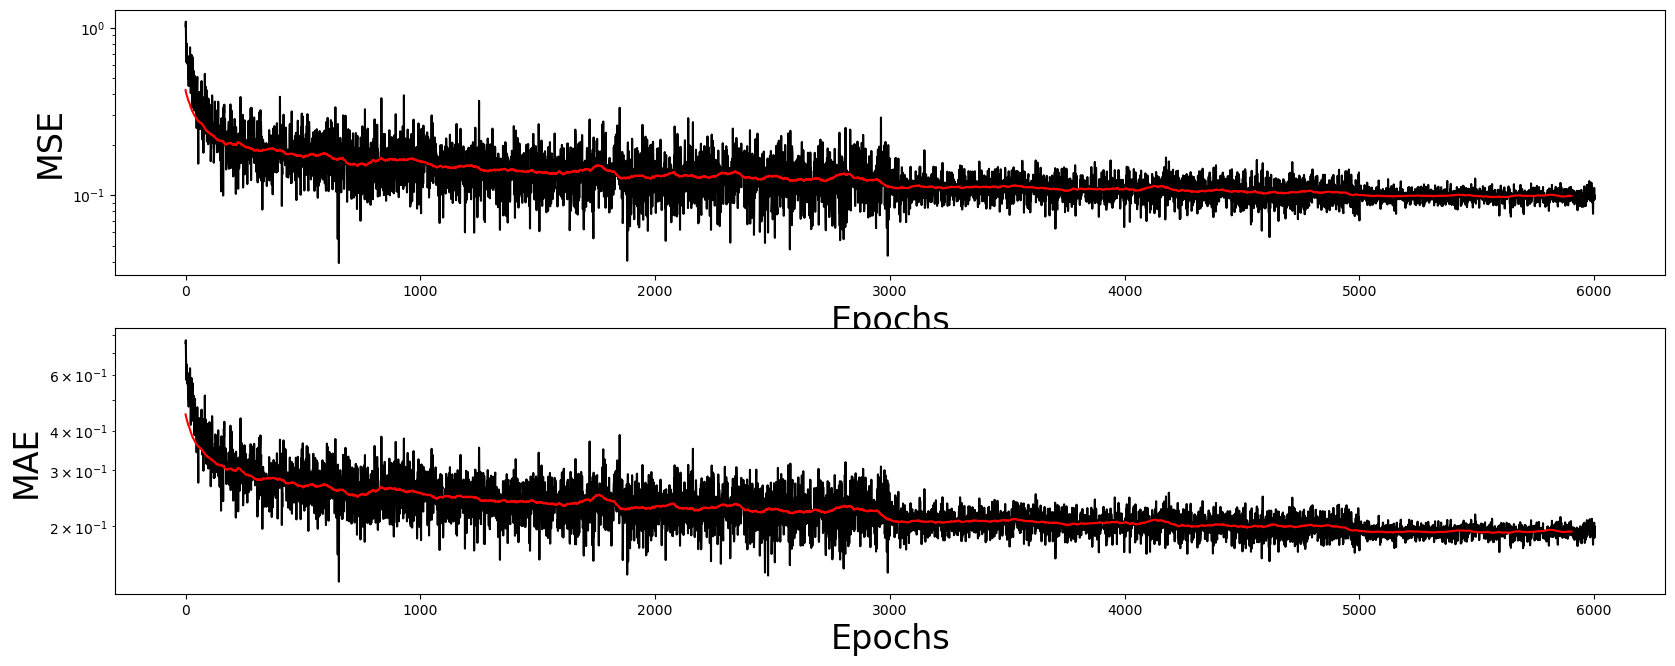

In [9]:
### Plot learning performance
number_of_timesteps_for_average = 100
plot_learning_performance(training_history_GRU, number_of_timesteps_for_average)

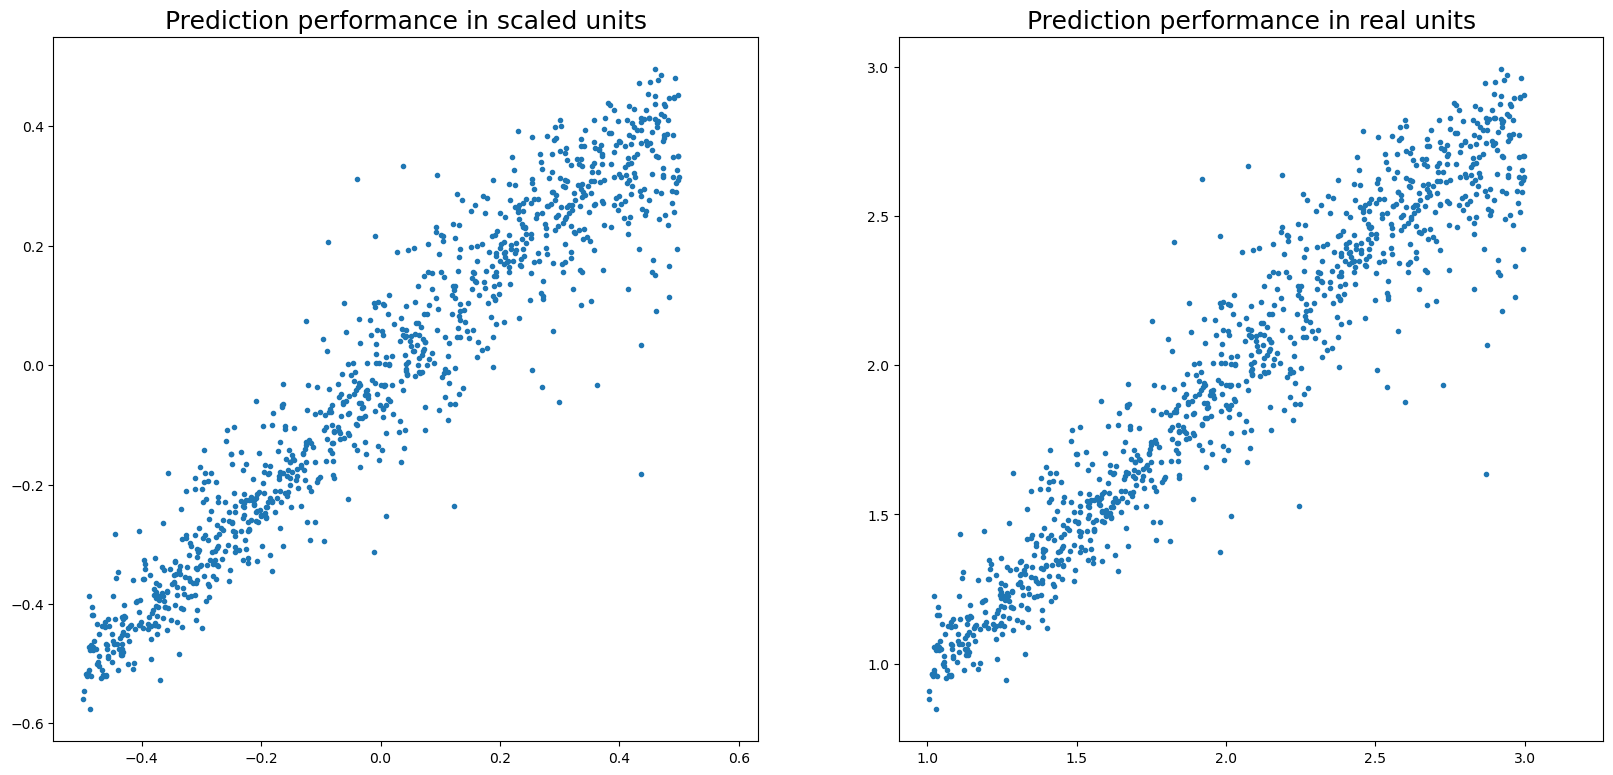

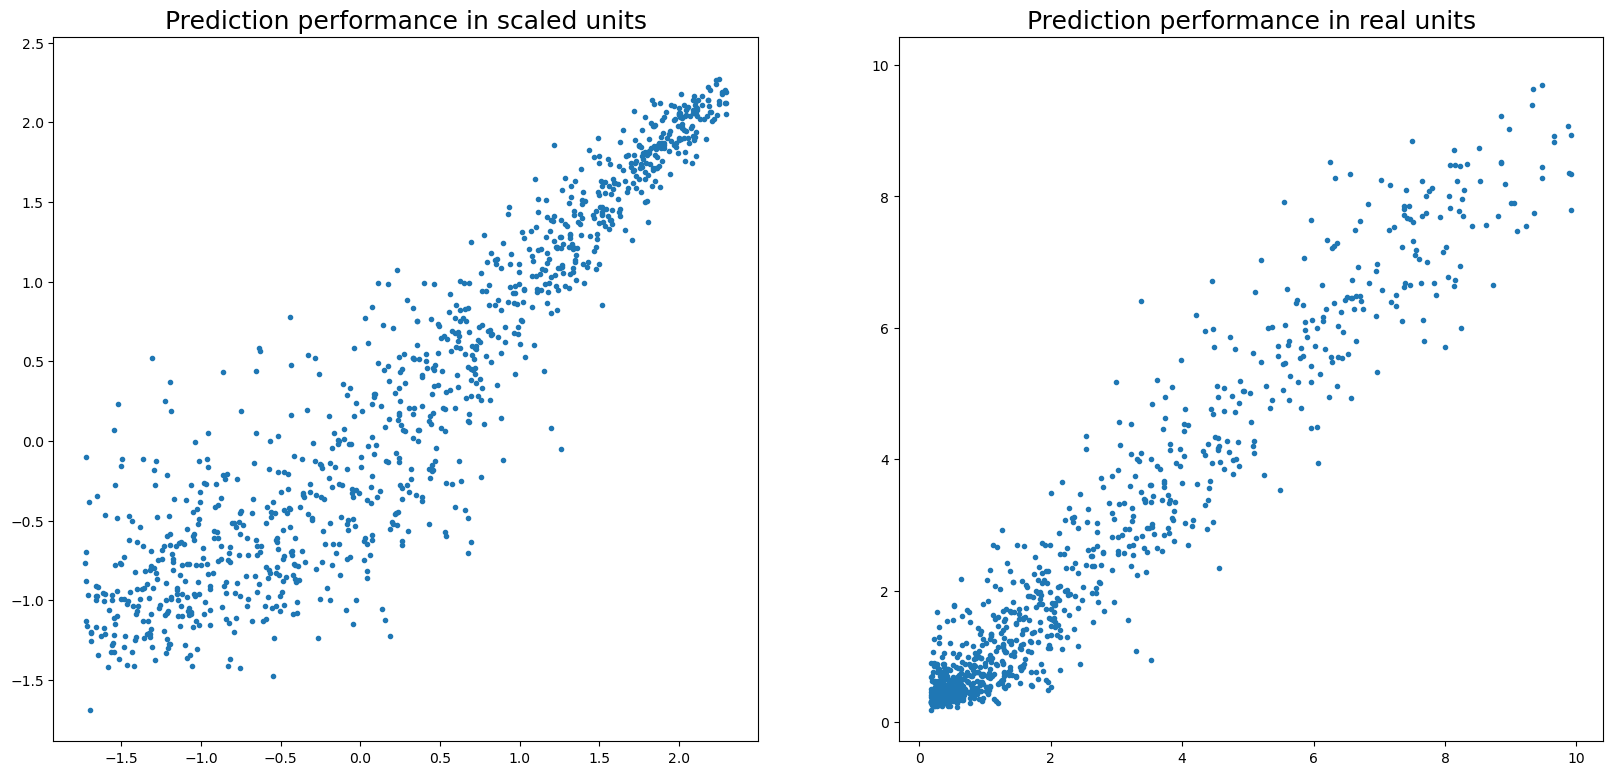

In [11]:
### Plot test performance
plot_test_performance(prediction_GRU_test[0], prediction_GRU_test[1], prediction_GRU_test[2], prediction_GRU_test[3], networkGRU)